#### Importing essential libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tt 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder 
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from tqdm.notebook import tqdm

In [2]:
#Train data and Test data directory
train_dir = 'Train'
test_dir = 'Test'

In [3]:
#Printing the number of classes in the dataset
print('No of Classes in the dataset:')
print(os.listdir(test_dir))

No of Classes in the dataset:
['.DS_Store', 'Others', 'MonkeyPox']


Defining the transformations needed to augment the dataset, thus allowing for better generalization and  preventing overfitting

In [4]:
#Transformations for Train dataset
train_tf = tt.Compose([         
    tt.ColorJitter(brightness=0.2),
    tt.Resize(size=(150,150)),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(5),
    tt.ToTensor(),            
])

#Transformations for Test dataset
test_tf= tt.Compose([   
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

In [5]:
#Reading the images
train_ds = ImageFolder(train_dir,train_tf)
test_ds = ImageFolder(test_dir,test_tf)

#Printing the size of the datasets
print("Train dataset size: ",len(train_ds))
print("Train dataset size: ",len(test_ds))

#Printing the size of the image
img,label=train_ds[0]
print("Image shape: ",img.shape)

Train dataset size:  3598
Train dataset size:  343
Image shape:  torch.Size([3, 150, 150])


In [6]:
print('Train dataset information:')
dataset_size=len(train_ds)
classes = train_ds.classes
num_classes = len(classes)
print('Size of the dataset:' + str(dataset_size))
print('Number of classes:' + str(num_classes)) 

#Counting the sample size of every class
count = []     
for x in range(num_classes):
    count.append(0)

for x in range(dataset_size):
    count[train_ds[x][1]]+=1
    
print('Samples for every class:')
    
#Print the count
for x in range(num_classes):
    print(classes[x] + " : " + str(count[x]))
    


Train dataset information:
Size of the dataset:3598
Number of classes:2
Samples for every class:
MonkeyPox : 1530
Others : 2068


In [7]:
print('Test data information:')
dataset_size=len(test_ds)
classes = test_ds.classes
num_classes = len(classes)
print('Size of the dataset:' + str(dataset_size))
print('Number of classes:' + str(num_classes)) 

#Counting the sample size of every class
count = []     
for x in range(num_classes):
    count.append(0)

for x in range(dataset_size):
    count[test_ds[x][1]]+=1
    
print('Samples for every class:')
    
#Print the count
for x in range(num_classes):
    print(classes[x] + " : " + str(count[x]))
    


Test data information:
Size of the dataset:343
Number of classes:2
Samples for every class:
MonkeyPox : 151
Others : 192


Separating the data in batches, so that one can load it on the GPU.

In [8]:
batch_size = 254

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=True,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=False,
    pin_memory=True
)

Visualizing some of the samples to see the transformations

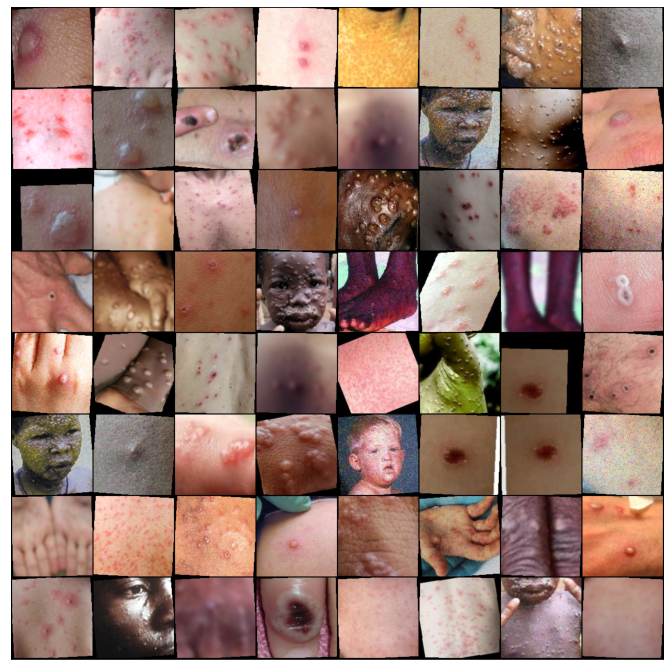

In [10]:
%matplotlib inline
for images, labels in train_dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
    break

Defining helper class and functions to pass the data and networks to the GPU, for processing

In [11]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Moving tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrapping a dataloader to move data to another device
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yielding a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Return the number of batches
        return len(self.dl)

In [12]:
#Checking the device
device = get_default_device() 
device

device(type='cpu')

In [13]:
#Transfering train data and Test data to the GPU if availiable
train_dl = DeviceDataLoader(train_dl, device) 
test_dl = DeviceDataLoader(test_dl, device)

#### Defining the Networks

Creating the base network class, so that steps that are general for training and data handling can happen independent (to a certain degree) of the specific network architecture.

Accuracy function counts the amount of correct predictions and divides it with the size of the batch, to give a metric of how good the network it's getting.



In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Functions of the base network

 **training_step**: to pass training batch trough the network and calculate the loss<br>
 **validation step**: similar to training but used for test data, the only difference is that this one also calculates the accuracy and returns both results.<br>
 **validation_epoch_end**: once a whole validation data is passed through this function is going to return the mean loss and accuracy.<br>
 **epoch_end**: to track performance during training showing loss and accuracy on every epoch.<br>

In [15]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        #Generate the predictions
        out = self(images)
        #Calculate the loss
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        #Generate the predictions
        out = self(images) 
        #Calculate the loss
        loss = F.cross_entropy(out, labels)
        #Calculate the accuracy
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        #Combine the losses
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        #Combine the accuracies
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

#### Defining ResNet9

Defining the network architecture. <br>
It is a small ResNet from each of its layers, which are a series of convolutional blocks that encapsulate a convolutional layer, normalization of the data, a nonlinear activation function (RELU) and in some steps a max pooling layer.

The specific implementation the architecture is as follows:

Convolutional Block (CL-Norm-ReLu), output shape: 32x150x150 <br>
Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 64x37x37<br>
Residual Block (ConvB-ConvB), output shape: 64x37x37<br>
Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 128x9x9<br>
Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 256x2x2<br>
Residual Block (ConvB-ConvB), output shape: 256x2x2<br>
Final block (MaxPool2-Lineal Layer), output shape: 1<br>

The residual block is actually a couple of convolutional blocks, this means this network has 9 "blocks", so it is called ResNet9.

In [16]:
def conv_block(in_channels, out_channels, pool=False,p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #32x150x150
        self.conv1 = conv_block(in_channels, 32)
        #64x37x37
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        #128x9x9
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)    
        #256x2x2
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        #256x1x1
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     
                                        nn.Flatten(), 
                                        nn.Linear(256, num_classes))
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.classifier(out)
        
        return out

#### Defining ResNet34

This architecture is a bigger version of the implemented ResNet(shown above), that allows for a deeper and potentially more powerful network. <br>
This architecture already exists on pythorch Libraries pre trained, which means it already knows how to classify images, thus taking advantage of that training and adapt it to this specific problem. <br>
However, the last layer needs some update, it is replaced with a simple linear layer with the number of classes of the project.

In [17]:
class Resnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(weights='ResNet34_Weights.DEFAULT')
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

Creating some functions to automatize and simplify training independent of the network.

**evaluate**: runs the validation step for each batch to get the loss and accuracy for the test dataset<br>
**get_lr**: returns the current learning rate<br>
**fit_one_cycle**: training function, the parameters are as follows:<br>

    epochs: the number of epochs for training
    Maximum learning rate: updating the learning rate for each epoch by using a one cycle learning rate scheduler
    Model: the network
    Train Loader: Training dataset
    Val Loader: Test dataset
    Weight decay: a weight decay that can be configured
    Grad clip: if gradient clipping is needed desired then it can be set
    opt_func: the desired optimization function

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Setting up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Setting up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Train Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Updating learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
def plot_scores(history):
    #plotting the accuracy for each epoch
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [20]:
def plot_losses(history):
    #plotting training and validation loss for each epoch
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [21]:
def show_sample(img, target):
    #getting prediction for an image
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    #convertting to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    #getting predictions from model
    yb = model(xb)
    #picking up the index with highest probability
    _, preds  = torch.max(yb, dim=1)
    #retrieving the class label
    show_sample(img,test_ds.classes[preds[0].item()])

#### Running ResNet9

In [22]:
model = to_device(ResNet9(3,6), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [23]:
#Checking the Base performance:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 1.831608772277832, 'val_acc': 0.0}]

In [24]:
#Hyperparameters for training
epochs = 3
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [25]:
%%time
#training
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00099, train_loss: 1.6661, val_loss: 0.9391, val_acc: 0.7028


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00046, train_loss: 0.5670, val_loss: 0.5631, val_acc: 0.7106


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00000, train_loss: 0.5149, val_loss: 0.3777, val_acc: 0.8602
CPU times: user 25min 47s, sys: 4min 46s, total: 30min 34s
Wall time: 33min 50s


#### Results

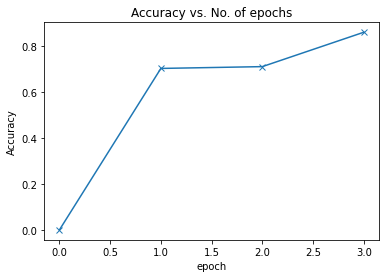

In [26]:
plot_scores(history)

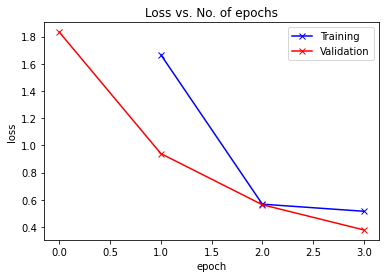

In [27]:
plot_losses(history)

Labels: Others


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


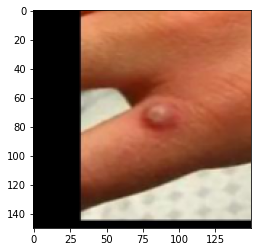

In [28]:
#Predicting some images
predict_image(test_ds[3][0],model)

Labels: Others


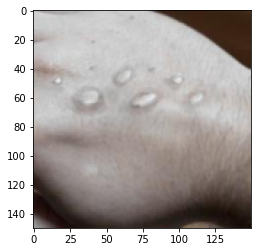

In [29]:
#Predicting some images
predict_image(test_ds[22][0],model)

#### Running ResNet34

In [30]:
model = to_device(Resnet34(), device)
model

Resnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [31]:
#Checking the Base performance:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 0.7135422229766846, 'val_acc': 0.35399892926216125}]

In [32]:
#hyperparameters
epochs2 = 3
max_lr2 = 0.00005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
#training only the last layer**
model.freeze()

In [34]:
%%time
#training
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00005, train_loss: 0.6588, val_loss: 0.5920, val_acc: 0.6878


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00002, train_loss: 0.4780, val_loss: 0.5138, val_acc: 0.7809


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00000, train_loss: 0.4071, val_loss: 0.4032, val_acc: 0.9733
CPU times: user 58min 1s, sys: 1min 34s, total: 59min 35s
Wall time: 1h 1min 20s


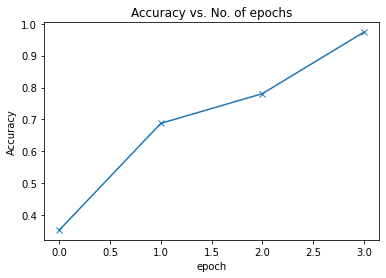

In [35]:
plot_scores(history)

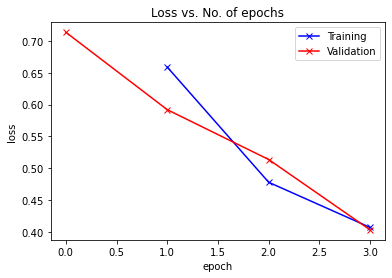

In [36]:
plot_losses(history)

Labels: MonkeyPox


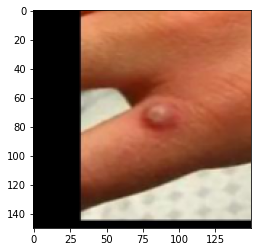

In [37]:
#Predicting some images
predict_image(test_ds[3][0],model)

Labels: MonkeyPox


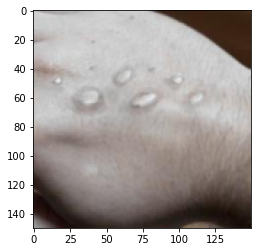

In [38]:
#Predicting some images
predict_image(test_ds[22][0],model)